In [26]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import os

In [ ]:
MODEL_NAME = "gpt2-xl" 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model: {MODEL_NAME} on {DEVICE}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

Loading model: gpt2-xl on cuda...



GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

# Podpunkt a

In [3]:
dataset = load_dataset("tasksource/babi_nli", "agents-motivations", split="train")

In [ ]:
def prepare_room_data(dataset):
    data_points = []
    state_keywords = ["tired", "hungry", "thirsty", "bored", "sleepy"]

    unique_labels = set()

    for item in dataset:
        if item["label"] == 1:
            raw_premise = item["premise"]
            raw_hypothesis = item["hypothesis"]
            hyp_words = raw_hypothesis.strip(".").split()
            target_room = hyp_words[-1]
            hypothesis_part = " ".join(hyp_words[:-1])
            sentences = [s.strip() for s in raw_premise.split(".") if s.strip()]
            
            if not sentences:
                continue

            last_premise_sentence = sentences[-1]
            last_premise_sentence = last_premise_sentence + "."
            input_text = last_premise_sentence + " " + hypothesis_part
            words = input_text.replace(".", "").split()
            subject_name = words[0]
            current_state = next((w for w in words if w in state_keywords), None)
            hypo_subject = hypothesis_part.split()[0]
            if subject_name != hypo_subject:
                continue

            if current_state and target_room:
                unique_labels.add(target_room)
                data_points.append(
                    {
                        "text": input_text,
                        "label_txt": target_room,
                        "subject": subject_name,
                        "state": current_state,
                    }
                )

    label_map = {name: i for i, name in enumerate(sorted(unique_labels))}
    print(f"Znalezione etykiety (pokoje): {label_map}")
    print(f"Liczba przykładów po filtrowaniu: {len(data_points)}")

    if data_points:
        print("Przykładowy punkt danych:", data_points[0])

    return data_points, label_map

In [5]:
data, label_map = prepare_room_data(dataset)

Znalezione etykiety (pokoje): {'bedroom': 0, 'garden': 1, 'kitchen': 2}
Liczba przykładów po filtrowaniu: 193
Przykładowy punkt danych: {'text': 'Jason is bored. Jason will go to the', 'label_txt': 'garden', 'subject': 'Jason', 'state': 'bored'}


In [ ]:
def get_token_indices_robust(text, tokenizer, subject, state):
    """
    Znajduje indeksy tokenów w oparciu o ich pozycję końcową w tekście.
    Rozwiązuje problem spacji i dzielenia słów (Sum+it vs Jason).
    """

    enc = tokenizer(text, return_tensors="pt", return_offsets_mapping=True)
    offsets = enc["offset_mapping"][0].tolist() 
    s1_start = text.find(subject)
    if s1_start == -1: return None 
    s1_end_char = s1_start + len(subject)
    
    s2_start = text.find(subject, s1_end_char + 1)
    s2_end_char = s2_start + len(subject) if s2_start != -1 else -1

    state_start = text.find(state)
    state_end_char = state_start + len(state) if state_start != -1 else -1
    
    indices = {
        "Subject 1": None,
        "State": None,
        "Subject 2": None,
        "Last Token": -1 
    }
    

    for idx, (t_start, t_end) in enumerate(offsets):
        if t_start == t_end: continue

        if t_end == s1_end_char:
            indices["Subject 1"] = idx
            
        if t_end == s2_end_char:
            indices["Subject 2"] = idx
            
        if t_end == state_end_char:
            indices["State"] = idx
            
    return indices

In [ ]:
def extract_activations_robust(model, tokenizer, data, label_map):
    num_layers = model.config.n_layer + 1
    positions = ["Subject 1", "State", "Subject 2", "Last Token"]
    
    storage = {l: {p: [] for p in positions} for l in range(num_layers)}
    labels_list = []
    
    print("Pobieranie aktywacji...")
    for item in tqdm(data):
        indices = get_token_indices_robust(item['text'], tokenizer, item['subject'], item['state'])
        
        if any(v is None for v in indices.values()):
            continue
            
        inputs = tokenizer(item['text'], return_tensors="pt").to(model.device)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            
        labels_list.append(label_map[item['label_txt']])
        
        for l_idx, hidden_state in enumerate(outputs.hidden_states):
            for pos_name in positions:
                idx = indices[pos_name]
                vec = hidden_state[0, idx, :].cpu().numpy()
                storage[l_idx][pos_name].append(vec)
                
    return storage, labels_list

activations_data, targets = extract_activations_robust(model, tokenizer, data, label_map)

Pobieranie aktywacji...


100%|██████████| 193/193 [00:23<00:00,  8.32it/s]


In [ ]:
print("Trenowanie sond...")
results = []
positions_of_interest = ["Subject 1", "State", "Subject 2", "Last Token"]



for layer in activations_data:
    for pos in positions_of_interest:
        X = np.array(activations_data[layer][pos])
        y = np.array(targets)
        
        # Podział train/test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Prosty klasyfikator liniowy
        clf = LogisticRegression(max_iter=2000)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        
        results.append({
            "Layer": layer,
            "Position": pos,
            "Accuracy": acc
        })

if os.path.exists("/outputs/df_results.pkl"):
    df_results = pd.read_pickle("/outputs/df_results.pkl")
    print("Wczytano wyniki z pliku df_results.pkl")
else:
    df_results = pd.DataFrame(results)
    df_results.to_pickle("/outputs/df_results.pkl")

Trenowanie sond...


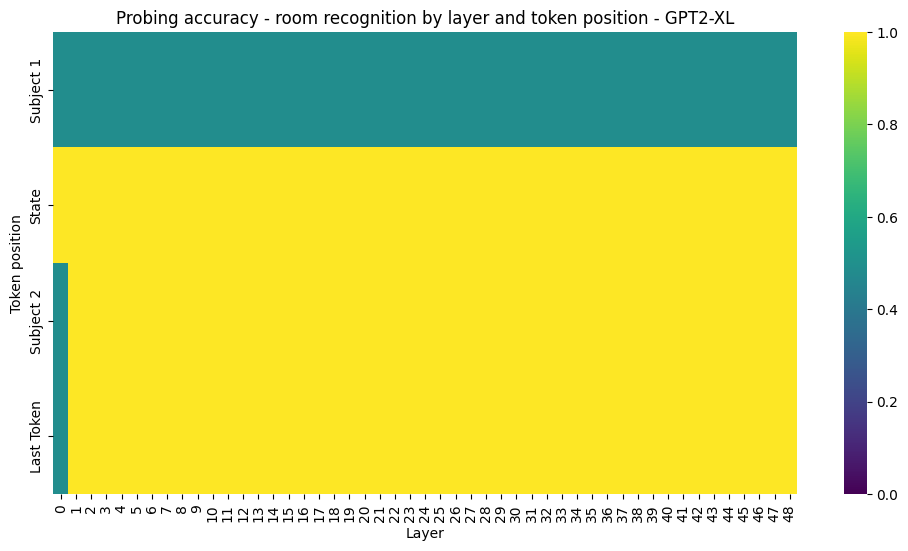

In [ ]:
heatmap_data = df_results.pivot(index="Position", columns="Layer", values="Accuracy")
heatmap_data = heatmap_data.reindex(positions_of_interest)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap="viridis", vmin=0, vmax=1)
plt.title("Probing accuracy - room recognition by layer and token position - GPT2-XL")
plt.xlabel("Layer")
plt.ylabel("Token position")
plt.show()

# Podpunkt c

In [12]:
dataset_induction = load_dataset("tasksource/babi_nli", "basic-induction", split="train")

In [ ]:
def prepare_induction_data(dataset):
    data_points = []
    known_colors = ["white", "yellow", "green", "gray", "black", "pink", "blue", "brown"]
    
    unique_labels = set()
    
    for item in dataset:
        if item['label'] == 1:
            raw_premise = item['premise']     
            raw_hypothesis = item['hypothesis'] 
            
            hyp_words = raw_hypothesis.strip(".").split()
            target_color = hyp_words[-1] 

            hypothesis_trigger = " ".join(hyp_words[:-1]) 
            
            if target_color not in known_colors:
                continue

            input_text = raw_premise + " " + hypothesis_trigger

            subject2 = hyp_words[0]
            

            premise_sentences = raw_premise.split('.')
            bridge_sentence = ""
            for sent in reversed(premise_sentences):
                if subject2 in sent:
                    bridge_sentence = sent
                    break

            animal = bridge_sentence.strip().split()[-1] 

            unique_labels.add(target_color)
            data_points.append({
                "text": input_text,
                "label_txt": target_color,
                "subject2": subject2,
                "animal": animal,      
                "color_src": target_color 
            })

    label_map = {name: i for i, name in enumerate(sorted(unique_labels))}
    print(f"Znalezione etykiety (kolory): {label_map}")
    print(f"Liczba przykładów: {len(data_points)}")
    
    if data_points:
        print("Przykładowy input:", data_points[0]['text'])
        print("Metadane:", data_points[0])
        
    return data_points, label_map

data_c, label_map_c = prepare_induction_data(dataset_induction)

Znalezione etykiety (kolory): {'gray': 0, 'green': 1, 'white': 2, 'yellow': 3}
Liczba przykładów: 503
Przykładowy input: Lily is a rhino. Lily is white. Bernhard is a swan. Brian is a lion. Bernhard is white. Julius is a rhino. Julius is white. Brian is yellow. Greg is a lion. Greg is
Metadane: {'text': 'Lily is a rhino. Lily is white. Bernhard is a swan. Brian is a lion. Bernhard is white. Julius is a rhino. Julius is white. Brian is yellow. Greg is a lion. Greg is', 'label_txt': 'yellow', 'subject2': 'Greg', 'animal': 'lion', 'color_src': 'yellow'}


In [19]:
data_c

[{'text': 'Lily is a rhino. Lily is white. Bernhard is a swan. Brian is a lion. Bernhard is white. Julius is a rhino. Julius is white. Brian is yellow. Greg is a lion. Greg is',
  'label_txt': 'yellow',
  'subject2': 'Greg',
  'animal': 'lion',
  'color_src': 'yellow'},
 {'text': 'Brian is a lion. Bernhard is a frog. Lily is a lion. Bernhard is yellow. Greg is a swan. Greg is gray. Julius is a swan. Julius is yellow. Lily is white. Brian is',
  'label_txt': 'white',
  'subject2': 'Brian',
  'animal': 'lion',
  'color_src': 'white'},
 {'text': 'Julius is a rhino. Greg is a lion. Brian is a swan. Julius is green. Lily is a rhino. Greg is yellow. Bernhard is a lion. Bernhard is green. Brian is white. Lily is',
  'label_txt': 'green',
  'subject2': 'Lily',
  'animal': 'rhino',
  'color_src': 'green'},
 {'text': 'Bernhard is a swan. Julius is a lion. Julius is green. Brian is a frog. Bernhard is white. Brian is white. Greg is a rhino. Greg is green. Lily is a rhino. Lily is',
  'label_txt':

In [ ]:
def get_induction_indices_robust(text, tokenizer, subject2, animal, color_src):
    """
    Znajduje indeksy dla kluczowych elementów indukcji.
    """
    enc = tokenizer(text, return_tensors="pt", return_offsets_mapping=True)
    offsets = enc["offset_mapping"][0].tolist()
    
    color_start = text.find(color_src) 
    if color_start == -1: return {k: None for k in ["Color Source", "Subject 2", "Animal 2", "Last Token"]}
    color_end = color_start + len(color_src)

    subj2_start = text.rfind(subject2)
    subj2_end = subj2_start + len(subject2)
    
    animal_start = text.rfind(animal)
    animal_end = animal_start + len(animal)
    
    indices = {
        "Color Source": None,
        "Animal 2": None,
        "Subject 2": None,
        "Last Token": -1 
    }
    
    for idx, (t_start, t_end) in enumerate(offsets):
        if t_start == t_end: continue
        
        if t_end == color_end:
            indices["Color Source"] = idx
        
        if t_end == animal_end:
            indices["Animal 2"] = idx
            
        if t_end == subj2_end:
            indices["Subject 2"] = idx
            
    return indices

In [21]:
def get_the_tokens_and_ids(tokenizer,base_text):
    inputs = tokenizer(base_text, return_tensors="pt")
    input_ids = inputs["input_ids"][0]
    tokens_and_ids = []
    for idx, token_id in enumerate(input_ids):
        token_str = tokenizer.decode(token_id)
        tokens_and_ids.append((idx, token_str, token_id.item()))
    return tokens_and_ids

In [24]:
get_the_tokens_and_ids(tokenizer, data_c[1]['text'])

[(0, 'Brian', 24761),
 (1, ' is', 318),
 (2, ' a', 257),
 (3, ' lion', 18744),
 (4, '.', 13),
 (5, ' Bern', 6206),
 (6, 'hard', 10424),
 (7, ' is', 318),
 (8, ' a', 257),
 (9, ' frog', 21264),
 (10, '.', 13),
 (11, ' Lily', 20037),
 (12, ' is', 318),
 (13, ' a', 257),
 (14, ' lion', 18744),
 (15, '.', 13),
 (16, ' Bern', 6206),
 (17, 'hard', 10424),
 (18, ' is', 318),
 (19, ' yellow', 7872),
 (20, '.', 13),
 (21, ' Greg', 8547),
 (22, ' is', 318),
 (23, ' a', 257),
 (24, ' sw', 1509),
 (25, 'an', 272),
 (26, '.', 13),
 (27, ' Greg', 8547),
 (28, ' is', 318),
 (29, ' gray', 12768),
 (30, '.', 13),
 (31, ' Julius', 32834),
 (32, ' is', 318),
 (33, ' a', 257),
 (34, ' sw', 1509),
 (35, 'an', 272),
 (36, '.', 13),
 (37, ' Julius', 32834),
 (38, ' is', 318),
 (39, ' yellow', 7872),
 (40, '.', 13),
 (41, ' Lily', 20037),
 (42, ' is', 318),
 (43, ' white', 2330),
 (44, '.', 13),
 (45, ' Brian', 8403),
 (46, ' is', 318)]

In [23]:
get_induction_indices_robust(data_c[1]['text'], tokenizer, data_c[1]['subject2'], data_c[1]['animal'], data_c[1]['color_src'])

{'Color Source': 43, 'Animal 2': 14, 'Subject 2': 45, 'Last Token': -1}

In [ ]:
import os


def run_induction_experiment(model, tokenizer, data, label_map):
    num_layers = model.config.n_layer + 1
    positions_of_interest = ["Color Source", "Animal 2", "Subject 2", "Last Token"]
    
    storage = {l: {p: [] for p in positions_of_interest} for l in range(num_layers)}
    labels_list = []
    
    print("Pobieranie aktywacji (Induction)...")
    subset_data = data[:500] if len(data) > 500 else data
    
    for item in tqdm(subset_data):
        # Pobieramy indeksy
        indices = get_induction_indices_robust(
            item['text'], 
            tokenizer, 
            item['subject2'], 
            item['animal'], 
            item['color_src']
        )
        
        # Walidacja: czy znaleziono wszystkie
        if any(v is None for v in indices.values()):
            continue
            
        inputs = tokenizer(item['text'], return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            
        labels_list.append(label_map[item['label_txt']])
        
        for l_idx, hidden_state in enumerate(outputs.hidden_states):
            for pos_name in positions_of_interest:
                idx = indices[pos_name]
                vec = hidden_state[0, idx, :].cpu().numpy()
                storage[l_idx][pos_name].append(vec)
    
    print(f"Zebrano poprawne aktywacje dla {len(labels_list)} przykładów.")
    print("Trenowanie sond...")
    
    results = []
    y = np.array(labels_list)
    
    for l in range(num_layers):
        for p in positions_of_interest:
            X = np.array(storage[l][p])
            
            if len(X) == 0: continue
            

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            clf = LogisticRegression(max_iter=3000) 
            clf.fit(X_train, y_train)
            acc = clf.score(X_test, y_test)
            
            results.append({
                "Layer": l,
                "Position": p,
                "Accuracy": acc
            })
            
    return pd.DataFrame(results)

if os.path.exists("/outputs/df_results_c.pkl"):
    df_results_c = pd.read_pickle("/outputs/df_results_c.pkl")
    print("Wczytano wyniki z pliku df_results_c.pkl")
else:
    df_results_c = run_induction_experiment(model, tokenizer, data_c, label_map_c)
    df_results_c.to_pickle("/outputs/df_results_c.pkl")

Pobieranie aktywacji (Induction)...


100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


Zebrano poprawne aktywacje dla 500 przykładów.
Trenowanie sond...


c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

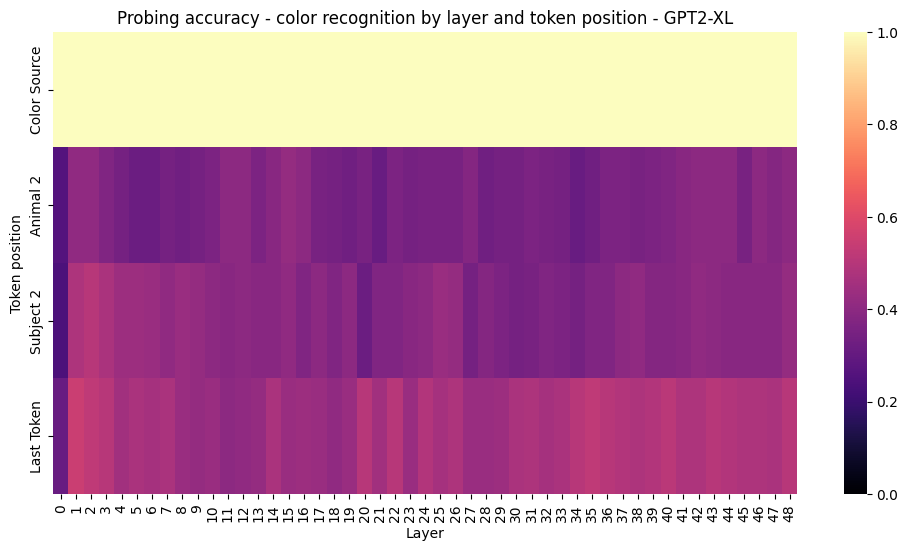

In [ ]:
heatmap_data_c = df_results_c.pivot(index="Position", columns="Layer", values="Accuracy")

heatmap_data_c = heatmap_data_c.reindex(["Color Source", "Animal 2", "Subject 2", "Last Token"])

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_c, annot=False, fmt=".2f", cmap="magma", vmin=0, vmax=1)
plt.title("Probing accuracy - color recognition by layer and token position - GPT2-XL")
plt.xlabel("Layer")
plt.ylabel("Token position")
plt.show()